#### IMPORT & LOAD MODEL

In [ ]:
import joblib
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
from pathlib import Path
# Load trained regressor
model = joblib.load(r"D:\HOCTAP\YDCC\backend\models\flood_xgb_classifier.pkl")
print("✅ Model loaded")


✅ Model loaded


#### LOAD INPUT RASTERS

In [3]:
from pathlib import Path

data_dir = Path(r"D:/HOCTAP/YDCC")

paths = {
    "VV": data_dir / "VV_dbscl_2022_9.tif",
    "slope": data_dir / "slope_dbscl.tif",
    "HAND": data_dir / "hand_dbscl.tif",
    "elevation": data_dir / "dem_dbscl.tif"
}

for k, p in paths.items():
    print(f"{k}: {p} → exists =", p.exists())


VV: D:\HOCTAP\YDCC\VV_dbscl_2022_9.tif → exists = True
slope: D:\HOCTAP\YDCC\slope_dbscl.tif → exists = True
HAND: D:\HOCTAP\YDCC\hand_dbscl.tif → exists = True
elevation: D:\HOCTAP\YDCC\dem_dbscl.tif → exists = True


#### LOAD RASTERS

In [7]:
src = {k: rasterio.open(p) for k, p in paths.items()}
arr = {k: src[k].read(1) for k in src}

for k in arr:
    print(k, arr[k].shape, arr[k].dtype)

VV (11141, 8536) float64
slope (11141, 8535) float32
HAND (3244, 4123) float32
elevation (11141, 8535) int16


#### CHECK CRS & RESOLUTION

In [10]:
import rasterio
from rasterio.warp import reproject, Resampling

# Load VV as reference
ref_src = rasterio.open(paths["VV"])
ref_arr = ref_src.read(1)

aligned = {"VV": ref_arr}

for k, p in paths.items():
    if k == "VV":
        continue

    with rasterio.open(p) as src:
        arr = np.empty_like(ref_arr, dtype=np.float32)

        reproject(
            source=src.read(1),
            destination=arr,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref_src.transform,
            dst_crs=ref_src.crs,
            resampling=Resampling.bilinear
        )

        aligned[k] = arr

for k in aligned:
    print(k, aligned[k].shape)


VV (11141, 8536)
slope (11141, 8536)
HAND (11141, 8536)
elevation (11141, 8536)


#### BUILD VALID MASK

In [15]:
mask = np.ones_like(aligned["VV"], dtype=bool)

for k in aligned:
    mask &= np.isfinite(aligned[k])

print("Valid pixels:", mask.sum())


Valid pixels: 58282205


#### BUILD FEATURE MATRIX

In [18]:
X = np.column_stack([
    aligned["VV"][mask],
    aligned["elevation"][mask],
    aligned["slope"][mask]
])

print("X shape:", X.shape)


X shape: (58282205, 3)


#### PREDICT FLOOD DEPTH

In [19]:
y_pred = model.predict(X)

print("Depth stats (m):")
print("  min :", y_pred.min())
print("  mean:", y_pred.mean())
print("  max :", y_pred.max())


Depth stats (m):
  min : 0
  mean: 0.02119466825251378
  max : 1


#### BUILD OUTPUT RASTER

In [21]:
# BUILD OUTPUT RASTER (SAFE)

depth_map = np.full(aligned["VV"].shape, np.nan, dtype=np.float32)

mask_flat = mask.flatten()
depth_flat = depth_map.flatten()

depth_flat[mask_flat] = y_pred
depth_map = depth_flat.reshape(aligned["VV"].shape)
print("Depth map built:", depth_map.shape)


Depth map built: (11141, 8536)


#### SAVE FLOOD DEPTH MAP

In [25]:
profile = ref_src.profile
profile.update(
    dtype=rasterio.float32,
    count=1,
    compress="lzw"
)

out_path = Path(r"D:/HOCTAP/YDCC/flood_depth_dbscl_2022_9_pred.tif")

with rasterio.open(out_path, "w", **profile) as dst:
    dst.write(depth_map.astype("float32"), 1)

print("💾 Saved:", out_path)


💾 Saved: D:\HOCTAP\YDCC\flood_depth_dbscl_2022_9_pred.tif


#### QUICK VISUAL CHECK

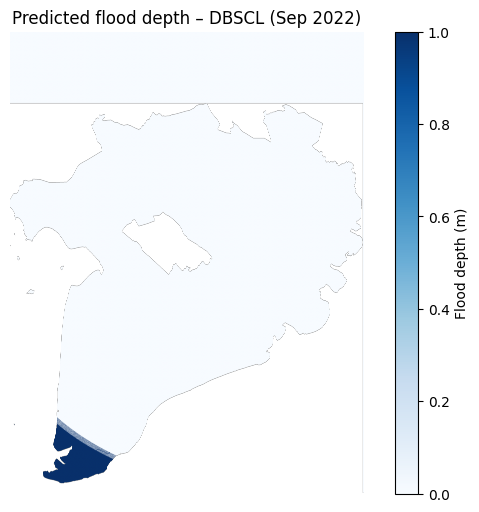

In [26]:
plt.figure(figsize=(8,6))
plt.imshow(depth_map, cmap="Blues")
plt.colorbar(label="Flood depth (m)")
plt.title("Predicted flood depth – DBSCL (Sep 2022)")
plt.axis("off")
plt.show()
